In [1]:
pip install --upgrade gensim==3.8.0

     |████████████████████████████████| 23.4 MB 6.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.0-cp39-cp39-linux_x86_64.whl size=23983933 sha256=09792dfaadfea056b1a628c9da2d9718222fc9a548e7b5f3ad5d1d6c2fa6db36
  Stored in directory: /aiffel/.cache/pip/wheels/fb/18/fa/2a0084905c1be0cead09a515d05015c1f939afb16fd7893ff4
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
import nltk
import gensim
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

지난 노드에서 __챗봇과 번역기는 같은 집안__ 이라고 했던 말을 기억하시나요?
앞서 배운 Seq2seq번역기와 Transfomer번역기에 적용할 수도 있겠지만, 이번 노드에서 배운 번역기 성능 측정법을 챗봇에도 적용해 봅시다. 배운 지식을 다양하게 활용할 수 있는 것도 중요한 능력이겠죠. 이번 프로젝트를 통해서 챗봇과 번역기가 같은 집안인지 확인해 보세요!

### Step 1. 데이터 다운로드
---
아래 파일 (ChatbotData.csv) 로드. csv 파일을 읽는 데에는 pandas 라이브러리가 적합. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장하기

* [songys/Chatbot_data](https://github.com/songys/Chatbot_data)

In [3]:
data = pd.read_csv('./ChatbotData_.csv')
data.head(-10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11808,화장 안했는데 썸남이 영통 걸었어. 어떡해?,화장실 불빛으로 좀 멀리 가리고 해보세요.,2
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.,2
11810,확실히 좋아하는 데도 관심 있는거 티 안내려고 선톡 안하고 일부러 늦게 보내고 그러...,많이 있어요.,2
11811,홧김에 짝남한테 고백했다.,화끈하시네요.,2


In [4]:
questions = data['Q']
answers = data['A']

# Step 2. 데이터 정제
아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요.

1. 영문자의 경우, 모두 소문자로 변환합니다.
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!

In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣0-9?.!,]+', ' ', sentence)
    
    return sentence

# Step 3. 데이터 토큰화

토큰화에는 KoNLPy의 mecab 클래스를 사용합니다.

아래 조건을 만족하는 build_corpus() 함수를 구현하세요!

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.

In [6]:
from konlpy.tag import Mecab
from collections import defaultdict

m = Mecab()

def build_corpus(src_data, tgt_data):
    """ 전처리 """
    preprocessed_src = list(map(preprocess_sentence, src_data))
    preprocessed_tgt = list(map(preprocess_sentence, tgt_data))
    
    """토큰화"""
    tok_sources = []
    tok_targets = []
    for src, tgt in zip(preprocessed_src, preprocessed_tgt):
        tok_src = m.morphs(src)
        tok_sources.append(tok_src)
        
        tok_tgt = m.morphs(tgt)
        tok_targets.append(tok_tgt)
    
    """토큰 개수 15 이상인 문장 삭제"""    
    drop_index_list = []
    for i, (src, tgt) in enumerate(zip(tok_sources, tok_targets)):
        if len(src) > 15 or len(tgt)> 15:
            drop_index_list.append(i)
    
    new_src_data = [tok_sources[i] for i in range(len(tok_sources)) if i not in drop_index_list]
    new_tgt_data = [tok_targets[i] for i in range(len(tok_targets)) if i not in drop_index_list]
    
    """중복 문장 제거"""
    index_dict_src = defaultdict(list)
    duplicates_src = []
    index_dict_tgt = defaultdict(list)
    duplicates_tgt = []

    # Find duplicates and track their indexes
    for i, (src, tgt) in enumerate(zip(new_src_data, new_tgt_data)):
        index_dict_src[tuple(src)].append(i)
        index_dict_tgt[tuple(tgt)].append(i)

    # 2회 이상 중복된 데이터의 index들 추출 (unique값은 남기기 위해 2 번째 인덱스부터 추출)
    for indices_src, indices_tgt in zip(index_dict_src.values(), index_dict_tgt.values()):
        if len(indices_src) > 1 or len(indices_tgt) > 1:
            duplicates_src.extend(indices_src[1:])
            duplicates_tgt.extend(indices_tgt[1:])
        
    duplicates_all = list(set(duplicates_src+duplicates_tgt))

    # 중복 데이터 제거(처음 등장한 문장은 keep)
    unique_src = [x for i, x in enumerate(new_src_data) if i not in duplicates_all]
    unique_tgt = [x for i, x in enumerate(new_tgt_data) if i not in duplicates_all]
    
    
    return tok_sources, tok_targets, unique_src, unique_tgt
   
    

__토큰화된 문장의 길이 분포 확인__<br>

토큰화된 Q와 A의 길이 제한을 15로 둘 경우 각각 3~5% 정도 데이터가 유실됨. 매우 적은 수치이므로 길이 제한을 15로 설정함.

In [7]:
tok_sources, tok_targets, que_corpus, ans_corpus = build_corpus(questions, answers)

질문 최소 길이 : 1
질문 최대 길이 : 32
질문 평균 길이 : 7.0266429840142095
답변 최소 길이 : 1
답변 최대 길이 : 40
답변 평균 길이 : 8.376554174067495


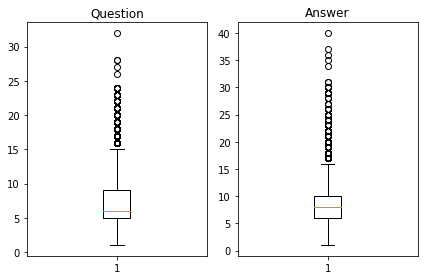

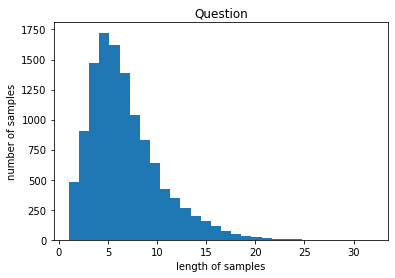

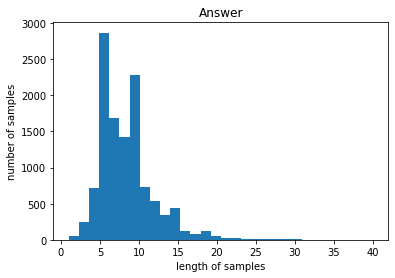

In [8]:
Q_len = [len(s) for s in tok_sources]
A_len = [len(s) for s in tok_targets]

print('질문 최소 길이 : {}'.format(np.min(Q_len)))
print('질문 최대 길이 : {}'.format(np.max(Q_len)))
print('질문 평균 길이 : {}'.format(np.mean(Q_len)))
print('답변 최소 길이 : {}'.format(np.min(A_len)))
print('답변 최대 길이 : {}'.format(np.max(A_len)))
print('답변 평균 길이 : {}'.format(np.mean(A_len)))

plt.subplot(1,2,1)
plt.boxplot(Q_len)
plt.title('Question')
plt.subplot(1,2,2)
plt.boxplot(A_len)
plt.title('Answer')
plt.tight_layout()
plt.show()

plt.title('Question')
plt.hist(Q_len, bins = 30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Answer')
plt.hist(A_len, bins = 30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
Q_len15 = [s for s in Q_len if s <= 15]
A_len15 = [s for s in A_len if s <= 15]

print('Q_len15 데이터 개수:', len(Q_len15))
print('A_len15데이터 개수:', len(A_len15))
print('Q_길이15 이하 데이터 비율: ', len(Q_len15)/len(Q_len))
print('A_길이15 이하 데이터 비율: ', len(A_len15)/len(A_len))

Q_len15 데이터 개수: 11489
A_len15데이터 개수: 11337
Q_길이15 이하 데이터 비율:  0.9717499788547745
A_길이15 이하 데이터 비율:  0.958893681806648


__중복 데이터 지운 후 데이터 개수 및 Q-A pair 유지 확인__<br>

질문 corpus와 답변 corpus의 데이터 개수가 __7097__ 개로 동일하고 __질문과 답변 쌍이 잘 유지__ 되어 있는 것을 확인함.

In [10]:
print("Unique src list length:", len(que_corpus))
print("Unique tgt list length:", len(ans_corpus))

Unique src list length: 7097
Unique tgt list length: 7097


In [11]:
print('que_corpus 7096 데이터',que_corpus[7096])
print('ans_corpus 7096 데이터',ans_corpus[7096])

que_corpus 7096 데이터 ['힘든', '연애', '좋', '은', '연애', '라는', '게', '무슨', '차이', '일까', '?']
ans_corpus 7096 데이터 ['잘', '헤어질', '수', '있', '는', '사이', '여부', '인', '거', '같', '아요', '.']


# Step 4. Augmentation

* 중복 데이터 처리 이후 데이터는 7100개가량으로 적은 편에 속함.
* __Lexical Substitution__ 을 적용해 데이터 증강.

* 아래 링크를 참고하여 __한국어로 사전 훈련된 Embedding 모델을 다운로드__
* Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하여, ko.bin 파일을 얻기

* [Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

* 다운로드한 모델을 활용해 __데이터를 Augmentation 하기!__
* 앞서 정의한 lexical_sub() 함수를 참고

* Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 __전체 데이터가 원래의 3배가량으로 늘어나도록__ 하기.

In [12]:
from gensim.models.word2vec import Word2Vec

wv = Word2Vec.load('./ko.bin')

잘 동작하는지 확인

In [13]:
wv.most_similar('감자')

/tmp/ipykernel_47/3095228173.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  wv.most_similar('감자')


[('야채', 0.8413219451904297),
 ('돼지고기', 0.8353288769721985),
 ('닭고기', 0.828442394733429),
 ('육류', 0.8231872320175171),
 ('옥수수', 0.8214879631996155),
 ('양배추', 0.8204459547996521),
 ('토마토', 0.817166805267334),
 ('밀가루', 0.8060519695281982),
 ('올리브유', 0.805986225605011),
 ('고구마', 0.8036344051361084)]

한 문장에서 한 단어(토큰)만 유사어로 바꾸는 lexical_sub() 구현

In [14]:
def lexical_sub(sentence, wv):
    selected_tok = random.choice(sentence)

    result = []
    for tok in sentence:
        if tok == selected_tok:
            try:
                similar_words = wv.most_similar(tok)
                if len(similar_words) > 0:
                    result += similar_words[0][0] + ' '
            except KeyError:
                result.append(tok)
        else:
            result.append(tok)

    return result


기존 데이터 쌍, 증강질문-기존답변 쌍, 기존질문-증강답변 쌍을 반환하는 augment_dataset() 구현

In [15]:
def augment_dataset(questions, answers, wv):
    augmented_questions = []
    augmented_answers = []
    
    for question, answer in zip(questions, answers):
        augmented_questions.append(question)
        augmented_answers.append(answer)
        
        augmented_question = lexical_sub(question, wv)
        augmented_answer = lexical_sub(answer, wv)
        
        augmented_questions.append(augmented_question)
        augmented_answers.append(answer)
        
        augmented_questions.append(question)
        augmented_answers.append(augmented_answer)
    
    return augmented_questions, augmented_answers


데이터 증강이 잘 구현되는지 확인<br>
* 하나의 문장에서 하나의 단어만 유사어로 바뀜
* 전체 데이터가 원래 대비 3배 늘어남

In [16]:

questions = [['12', '시', '땡', '!'], 
             ['가스', '비', '너무', '많이', '나왔', '다', '.'], 
             ['취향', '좀', '존중', '해', '줬', '으면']]
answers = [['하루', '가', '또', '가', '네요', '.'], 
           ['다음', '달', '에', '는', '더', '절약', '해', '봐요', '.'], 
           ['각자', '마다', '취향', '이', '있', '는', '거', '죠', '.']]

augmented_questions, augmented_answers = augment_dataset(questions, answers, wv)

# Print augmented question-answer pairs
for i in range(len(augmented_questions)):
    print("Q:", augmented_questions[i])
    print("A:", augmented_answers[i])
    print()

Q: ['12', '시', '땡', '!']
A: ['하루', '가', '또', '가', '네요', '.']

Q: ['12', '시', '끗', ' ', '!']
A: ['하루', '가', '또', '가', '네요', '.']

Q: ['12', '시', '땡', '!']
A: ['일', '주', '일', ' ', '가', '또', '가', '네요', '.']

Q: ['가스', '비', '너무', '많이', '나왔', '다', '.']
A: ['다음', '달', '에', '는', '더', '절약', '해', '봐요', '.']

Q: ['가스', '비', '너무', '많이', '나왔', '으', '며', ' ', '.']
A: ['다음', '달', '에', '는', '더', '절약', '해', '봐요', '.']

Q: ['가스', '비', '너무', '많이', '나왔', '다', '.']
A: ['다음', '달', '에', 'ㄴ', '다', '는', ' ', '더', '절약', '해', '봐요', '.']

Q: ['취향', '좀', '존중', '해', '줬', '으면']
A: ['각자', '마다', '취향', '이', '있', '는', '거', '죠', '.']

Q: ['취향', '조', '금', ' ', '존중', '해', '줬', '으면']
A: ['각자', '마다', '취향', '이', '있', '는', '거', '죠', '.']

Q: ['취향', '좀', '존중', '해', '줬', '으면']
A: ['각자', '마다', '취향', '그', '러', ' ', '있', '는', '거', '죠', '.']



/tmp/ipykernel_47/3742043412.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  similar_words = wv.most_similar(tok)


In [17]:
aug_que_corpus, aug_ans_corpus = augment_dataset(que_corpus, ans_corpus, wv)

/tmp/ipykernel_47/3742043412.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  similar_words = wv.most_similar(tok)


In [18]:
print('데이터 증강 뒤 Question 데이터 개수: ', len(aug_que_corpus))
print('데이터 증강 뒤 Answer 데이터 개수: ', len(aug_ans_corpus))

데이터 증강 뒤 Question 데이터 개수:  21291
데이터 증강 뒤 Answer 데이터 개수:  21291


# Step 5. 데이터 벡터화



__1. 타겟 데이터(answer) 전체에 \<start> 토큰과 \<end> 토큰 추가__

In [19]:
def add_start_end_tokens(sentences):
    augmented_sentences = []
    
    for sentence in sentences:
        augmented_sentence = ["<start>"] + sentence + ["<end>"]
        augmented_sentences.append(augmented_sentence)
    
    return augmented_sentences

In [20]:
aug_ans_corpus2 = add_start_end_tokens(aug_ans_corpus)

__2. 전체 데이터(aug_que_corpus, aug_ans_corpus2)에 대한 단어 사전 구축 및 벡터화__ 

enc_train 과 dec_train 반환

In [21]:
from collections import Counter

def vectorization(questions, answers, num_words=20000):
    counter = Counter()

    for q, a in zip(questions, answers):
        counter.update(q)
        counter.update(a)
        
    counter = counter.most_common(num_words-2)
    vocab = ['<PAD>', '<UNK>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index.get(word, word_to_index['<UNK>']) for word in wordlist]
    
    enc_train = []
    dec_train = []
    for wordlist_que, wordlist_ans in zip(questions, answers):
        enc = wordlist_to_indexlist(wordlist_que)
        dec = wordlist_to_indexlist(wordlist_ans)
        enc_train.append(enc)
        dec_train.append(dec)
    
    # counter, vocab은 확인용으로 반환함. 따로 쓰지는 않음
    return enc_train, dec_train, word_to_index, counter, vocab

In [22]:
enc_train, dec_train, word_to_index, counter, vocab = vectorization(aug_que_corpus, aug_ans_corpus2, num_words=20000)

In [23]:
Q_len = [len(s) for s in enc_train]
A_len = [len(s) for s in dec_train]

In [24]:
print('질문 최대 길이 : {}'.format(np.max(Q_len)))
print('답변 최대 길이 : {}'.format(np.max(A_len)))

질문 최대 길이 : 26
답변 최대 길이 : 23


데이터 증강을 하면서 최대 길이가 15에서 각각 21, 24로 증가함. MAX_LEN 30 에 맞춰 Padding 추가

In [25]:
MAX_LEN = 30

enc_train_pad = []
dec_train_pad = []

for enc, dec in zip(enc_train, dec_train):
    enc_pad = enc + [0] * (MAX_LEN - len(enc))
    dec_pad = dec + [0] * (MAX_LEN - len(dec))
    enc_train_pad.append(enc_pad)
    dec_train_pad.append(dec_pad)

질문과 답변 데이터를 묶어 배치 크기의 텐서로 만들어 주기

In [26]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train_pad, dec_train_pad)).batch(batch_size=BATCH_SIZE)

# Step 6. 훈련하기

* 데이터 크기가 작아 과적합 되기 쉬우니 하이퍼파라미터 튜닝 필요
> Hyperparameters<br>
n_layers: 1<br>d_model: 368<br>n_heads: 8<br>d_ff: 1024<br>dropout: 0.2<br>Training Parameters<br>
Warmup Steps: 1000<br>Batch Size: 64<br>Epoch At: 10<br>


In [27]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [28]:
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]


def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩마스크도 포함

    return tf.maximum(look_ahead_mask, padding_mask)

# def generate_lookahead_mask(size):
#     """
#     tf.linalg.band_part : 삼각 혹은 대각 행렬 구현 함수
#     tf.linalg.band_part(input, num_lower, num_upper, name=None)
#     num_lower 가 음수인 경우 하삼각행렬이 1로 채워짐
#     num_upper 가 음수인 경우 상삼각행렬이 1로 채워짐
#     대각 행렬이 0 으로 된 상삼각 행렬을 만들기 위해 '1 - ' 가 필요함.
#     하삼각 행렬 생성 -> 대각 행렬이 0인 상삼각 행렬 생성
#     """
#     mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0) # 하삼각행렬이 1로 채워진 행렬 생성
#     return mask

def generate_lookahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = generate_padding_mask(x) # 패딩마스크도 포함

    return tf.maximum(look_ahead_mask, padding_mask)


def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_mask = generate_lookahead_mask(tgt)
#    dec_tgt_padding_mask = generate_padding_mask(tgt)
#    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [29]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    # 밑으로 코드 구현
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [30]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out

In [31]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn


In [32]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [33]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        # TODO: 구현
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [34]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        # TODO: 구현
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
            
        return out, dec_attns, dec_enc_attns

In [35]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        # TODO: 구현
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        return out

    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        # TODO: 구현
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        return logits, enc_attns, dec_attns, dec_enc_attns

In [36]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=1,
    d_model=368,
    n_heads=8,
    d_ff=1024,
    dropout=0.2,
    src_vocab_size = len(vocab) + 2,
    tgt_vocab_size = len(vocab) + 2,
    pos_len=30,
    shared_fc=True,
    shared_emb=True)

d_model = 368

In [37]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        # TODO: 구현
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [38]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [39]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    # TODO: 구현
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [40]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    # TODO: 구현
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))    

    return loss, enc_attns, dec_attns, dec_enc_attns

In [42]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    # 전체 데이터셋을 batchsize로 나눠서 전체 학습 batch 개수를 반환함 즉, 1850
    # round(118370 / 64) = 1850
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    # [[YOUR CODE]]
    for (batch, (src, tgt)) in enumerate(train_dataset):
        """
        tf.data.experimental.cardinality(train_dataset).numpy() 이 코드로 이미 batch_size 만큼
        데이터들을 slicing 해서 src, tgt를 슬라이싱 했으므로 따로 slicing 할 필요 없음.
        """
        src = tf.cast(src, dtype=tf.int64)
        tgt = tf.cast(tgt, dtype=tf.int64)
        
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(src, tgt, transformer, optimizer)
        total_loss += batch_loss
        
        # Display progress
        tqdm_bar.set_description(f'Epoch {epoch+1}')
        tqdm_bar.set_postfix(loss=total_loss.numpy()/(batch+1))
        tqdm_bar.update(1)
    
    tqdm_bar.close()
    print(f'Epoch {epoch+1} Loss: {total_loss.numpy()/(batch+1):.4f}')

  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 1 Loss: 3.7512


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 2 Loss: 3.1028


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 3 Loss: 2.7345


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 4 Loss: 2.2706


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 5 Loss: 1.6844


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 6 Loss: 1.2152


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 7 Loss: 0.9364


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 8 Loss: 0.7407


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 9 Loss: 0.6044


  0%|          | 0/333 [00:00<?, ?it/s]

Epoch 10 Loss: 0.5074


# Step 7. 성능 측정하기

1. 주어진 질문에 적절한 답변을 하는지 확인
2. BLEU Score를 계산하는 calculate_bleu() 함수 이용해 수치적으로 평가

__1. 주어진 질문에 적절한 답변 하는지 확인__

In [43]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [44]:
word_to_index['<start>']

3

In [45]:
def evaluate(question, transformer):
    preprocessed_src = preprocess_sentence(question)
    que_temp = m.morphs(preprocessed_src)
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index.get(word, word_to_index['<UNK>']) for word in wordlist]
    
    enc_test = wordlist_to_indexlist(que_temp)
    _input = enc_test + [0] * (MAX_LEN - len(enc_test))
    _input = np.array(_input)
    _input = np.expand_dims(_input, 0)

    output = tf.expand_dims(word_to_index['<start>'], 0)

    output = tf.cast(output, tf.int32)
    
    output_array = tf.TensorArray(dtype=tf.int32,
                                      size=0,
                                      dynamic_size=True)   
    output_array = output_array.write(0, output)


    for i in range(MAX_LEN):
        output = tf.transpose(output_array.stack())
        enc_mask, dec_enc_mask, dec_mask = generate_masks(_input, output)
        
        predictions, enc_attns, dec_attns, dec_enc_attns = transformer(_input, output, enc_mask, dec_enc_mask, dec_mask)
        
        predictions = predictions[:, -1:, :] # 출력 맨 마지막 단어 벡터
        
        predicted_id = tf.argmax(predictions, axis=-1) # Softmax로 가장 높은 확률의 단어 추출
        predicted_id = tf.cast(predicted_id, dtype=tf.int32) # int64 로 변환
        output_array = output_array.write(i + 1, predicted_id[0]) # output_array의 마지막 부분에 작성
                  
        if predicted_id == word_to_index['<end>']:
            break
          
    output = tf.transpose(output_array.stack()).numpy()

    
    # Tok => 
    result=[]
    for tok in output[0]:
        word = index_to_word[tok]
        result.append(word)
        
    return question, result, enc_attns, dec_attns, dec_enc_attns

In [49]:
def translate(sentence, transformer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evalute(sentence, transformer)
    
    print('Question: {}'.format(sentence))
    print('Answer: {}'.format(result))

In [73]:
test_df = pd.DataFrame()

In [74]:
examples = ["홧김에 짝남한테 고백했다.",
            "지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."]

In [75]:
test_df["sample"] = examples
test_df

,sample
0,홧김에 짝남한테 고백했다.
1,"지루하다, 놀러가고 싶어."
2,오늘 일찍 일어났더니 피곤하다.
3,간만에 여자친구랑 데이트 하기로 했어.
4,집에 있는다는 소리야.


In [78]:
trans_list=[]
print('예문')
print('='*50)
for idx, sen in enumerate(examples):
    print(f'> {str(idx+1)}. {sen}')

    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sen, transformer)
    trans_list.append(result)
print('\n')
print('답변')
print('='*50)
for idx, sen in enumerate(trans_list):
    sen = sen[1:-1]
    sen = ' '.join(sen)
    print(f'> {str(idx+1)}. {sen}')

print('\n')
print('Hyperparameters')
print('='*50)

n_layers =  1
d_model = 368
n_heads = 8
d_ff = 1024
dropout = 0.2
warmup_steps = 1000

print('n_layers :',n_layers)
print('d_model :',d_model)
print('n_heads :',n_heads)
print('d_ff :',d_ff)
print('dropout :',dropout)
print('Warmup_steps :',warmup_steps)
print('BATCH_SIZE  :',BATCH_SIZE )
print('EPOCHS  :',EPOCHS )
    

예문
> 1. 홧김에 짝남한테 고백했다.
> 2. 지루하다, 놀러가고 싶어.
> 3. 오늘 일찍 일어났더니 피곤하다.
> 4. 간만에 여자친구랑 데이트 하기로 했어.
> 5. 집에 있는다는 소리야.


답변
> 1. 화끈 하 시 네요 .
> 2. 생각 을 하 고 나 서 하 고 가 는 것 이 좋 겠 네요 .
> 3. 사 는 것   처럼 , 나쁜 생각 이 나 봐요 .
> 4. 좋 은 마무리 가 되 길 바랄게요 .
> 5. 좋 은 사람 이 라면 먹 든 후폭풍 이 에요 .


Hyperparameters
n_layers : 1
d_model : 368
n_heads : 8
d_ff : 1024
dropout : 0.2
Warmup_steps : 1000
BATCH_SIZE  : 64
EPOCHS  : 10


__2. BLEU Score를 이용해 수치적으로 평가__

In [79]:
import nltk.translate.bleu_score as bleu
a = "화끈하시네요.".split()
b = "화끈 하 시 네요 .".split()
bleu.sentence_bleu( [b], a )

0

# 회고

* 이번 익스를 진행할 때, 토큰화를 하는 과정에서 케라스나 다른 라이브러리에 내장된 함수를 사용하지 않고, enumerate를 돌려 vocab과 토큰을 형성했는데, 이게 모든 재앙의 시작이 됨.
* 데이터 타입이 맞지 않아서 패딩도 케라스 내장함수로 구현 못해서 손수 해줬어야 했음.
* 더 문제는, 추론 과정(evaluate)에서 코드 한 줄 한 줄 실행할 때마다 온갖 에러가 다 났음.
* 민수님의 도움으로 추론과정을 무사히 실행할 수 있게 됨.
* 대부분의 문제는 'output'의 shape이 1D라 lookahead 마스크를  생성할 수 없거나 혹은, 어떤 코드는 'int32'를 default로 지정해서 반환하고 어떤 코드는 'int64'를 반환해서 충돌이 발생해 코드가 실행되지 않았음.
* 그래서 evaluate 코드를 보면 dtype을 'int32'로 변환해주는 부분이 매우 많음.
* 또 다른 문제는, 학습할 때 어떨 땐 문제없이 loss가 줄어들고 어떨 때는 loss가 nan으로 뜸. 이는, 코드를 돌릴 때마다 형태소 분석 이후 vocab size가 달라져서 embedding_dim이 vocab size보다 적게 입력된 것이 문제가 됨.
* src와 tgt vocab size를 len(vocab) + 2 로 지정한 이후로는 문제가 나지 않았음.
* bleu score는 데이터에 있는 Q&A 중 하나를 골라 평가함.
* 점수는 0점인데 그런게 당연함. 형태소 분석을 거쳤기 때문에 띄어쓰기가 매우 많이 되어 있어서 단어를 토대로 점수를 평가하는 bleu가 하나도 안맞는다고 평가할 수밖에 없음.
* 저 부분을 손보자니 기말고사 준비할 시간이 너무 부족할 것 같아 여기에서 만족하기로 함.....
* 이번 익스를 하며 느낀건, 내장 함수를 똑똑하게 활용하자....임.
* 코딩 실력, 코딩 해석, 내장함수 활용 등 다방면에서 나의 한계가 여실히 드러났던 주간이었음.